# Проект построение прогнозной модели для HR


## Описание проекта

Практическая ценность проекта заключается в возможности прогнозирования ухода сотрудников, снижения оттока персонала для служб HR.

На входе данные по удовлетворенности сотрудника. В свою очередь уровень удовлетворенности формируется на основе опросов сотрудников. На основании данных опросов строится модель предсказания уровня удовлетворенности. 
Вторая часть расчетов - прогноз вероятности ухода сотрудника. Исходя из этого кадровая служба может принять решение по заблаговременному поиску заменяющего кандидата на данную должность или предпринять усилия по удержанию сотрудника.

## Исходные данные
### Данные для расчета модели удовлетворенности предоставлены в виде файлов:

- Тренировочная выборка: train_job_satisfaction_rate.csv
- Входные признаки тестовой выборки: test_features.csv
- Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

Легенда:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.



### Данные для предсказания увольнения сотрудника представлены в виде файлов:
- Тренировочная выборка: train_quit.csv
- Входные признаки тестовой выборки те же, что и в прошлой задаче: test_features.csv
- Целевой признак тестовой выборки: test_target_quit.csv


## Загрузка данных
Но перед этим сделаем импорт необходимых библиотек и провдем настройки Jupyter Notebook

In [1]:
# Игнгорирование предупреждений системы
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
! pip install -q phik
! pip install -q shap
! pip install -q scikit-learn==1.4.1.post1
! pip install -q optuna-integration==3.6.0

In [3]:
# Импорт необходимых билиотек
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

import phik
import shap
from optuna.integration import OptunaSearchCV

# отображаем все столбцы и до 100 строк
pd.options.display.max_columns = 250
pd.options.display.max_rows = 100
#pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:20.2f}'.format

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Тренировочная выборка:
train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
# Входные признаки тестовой выборки:
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
# Целевой признак тестовой выборки:
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

Убеждаемся, что все загрузилось корректно.

In [5]:
display(train_job_satisfaction_rate.head())
display(test_features.head())
display(test_target_job_satisfaction_rate.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Названия колонок соответствуют PEP8. Смотрим фреймы методом info().

In [6]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В датафрейме 4000 записей. в колонках dept и level есть пропуски. Информация загрузилась корректкно.

In [7]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В датафрейме 2000 записей. В колонках dept и level есть пропуски. Информация загрузилась корректкно.

In [8]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Пропусков нет. Информация загрузилась корректкно.

Делаем общий вывод: данные загрузились корректно. В двух таблицах имеются строки с отсутствием значений, которые необходимо обработать, чем сейчас и займемся. Для удобства оценки данных воспользуемся написанной функцией, которую затем последовательно применяем к каждому фрейму.

In [9]:
def descr(df):
    '''
    Функция принимает датафрейм и выдает таблицу ключевых значений 
    по числовым и категориальным столбцам в компактном виде.
    '''
    df_describe = pd.DataFrame()
    for col in df.columns: 
        if df[col].dtypes in df.select_dtypes(include='number').dtypes.unique():
            df_describe[col] = [
                df[col].dtypes,
                df[col].isna().count(),
                df[col].count(),
                df[col].isna().sum(), 
                round(100*df[col].isna().sum()/df[col].isna().count(), 2),
                df[col].nunique(),
                df[col].min(),
                df[col].max(),
                df[col].duplicated().sum(),
                df[col].sort_values().unique()
            ]
        else:
            df_describe[col] = [
            df[col].dtypes,
            df[col].isna().count(),
            df[col].count(),
            df[col].isna().sum(), 
            round(100*df[col].isna().sum()/df[col].isna().count(), 2),
            df[col].nunique(),
            '-', 
            '-',
            df[col].duplicated().sum(),
            df[col].sort_values().unique()
        ]

    df_describe = df_describe.T
    df_describe.columns = ['Тип данных', 'Количество строк', 'Строк без пропусков', 'Количество пропусков', 'Пропуски, %', 'Количество уникальных', 'Минимум', 'Максимум', 'Количество дубликатов', 'Сэмпл']
    df_describe = df_describe.T
    return df_describe

In [10]:
descr(train_job_satisfaction_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
Тип данных,int64,object,object,object,int64,object,object,int64,int64,float64
Количество строк,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
Строк без пропусков,4000,3994,3996,4000,4000,4000,4000,4000,4000,4000
Количество пропусков,0,6,4,0,0,0,0,0,0,0
"Пропуски, %",0.00,0.15,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Количество уникальных,4000,5,3,3,10,2,2,5,68,98
Минимум,100954,-,-,-,1,-,-,1,12000,0.03
Максимум,999521,-,-,-,10,-,-,5,98400,1.00
Количество дубликатов,0,3994,3996,3997,3990,3998,3998,3995,3932,3902
Сэмпл,"[100954, 101057, 101074, 101081, 101129, 10115...","[hr, marketing, purchasing, sales, technology,...","[junior, middle, sinior, nan]","[high, low, medium]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[no, yes]","[no, yes]","[1, 2, 3, 4, 5]","[12000, 13200, 14400, 15600, 16800, 18000, 192...","[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1..."


Во фрейме rain_job_satisfaction_rate есть такие проблемы:
- 6 пропусков в разделе dept (департамент)
- 4 пропуска в разделе level (уровень)

In [11]:
descr(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
Тип данных,int64,object,object,object,int64,object,object,int64,int64
Количество строк,2000,2000,2000,2000,2000,2000,2000,2000,2000
Строк без пропусков,2000,1998,1999,2000,2000,2000,2000,2000,2000
Количество пропусков,0,2,1,0,0,0,0,0,0
"Пропуски, %",0.00,0.10,0.05,0.00,0.00,0.00,0.00,0.00,0.00
Количество уникальных,2000,6,3,4,10,2,2,5,66
Минимум,100298,-,-,-,1,-,-,1,12000
Максимум,999029,-,-,-,10,-,-,5,96000
Количество дубликатов,0,1993,1996,1996,1990,1998,1998,1995,1934
Сэмпл,"[100298, 100480, 100503, 100610, 100692, 10071...","[ , hr, marketing, purchasing, sales, technolo...","[junior, middle, sinior, nan]","[ , high, low, medium]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[no, yes]","[no, yes]","[1, 2, 3, 4, 5]","[12000, 13200, 14400, 15600, 16800, 18000, 192..."


Во фрейме test_features такие проблемы:
- 2 пропуска в разделе dept (департамент)
- 1 пропуск в разделе level (уровень)

In [12]:
descr(test_target_job_satisfaction_rate)

,id,job_satisfaction_rate
Тип данных,int64,float64
Количество строк,2000,2000
Строк без пропусков,2000,2000
Количество пропусков,0,0
"Пропуски, %",0.00,0.00
Количество уникальных,2000,98
Минимум,100298,0.03
Максимум,999029,1.00
Количество дубликатов,0,1902
Сэмпл,"[100298, 100480, 100503, 100610, 100692, 10071...","[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1..."


Во фрейме test_target_job_satisfaction_rate пропусков нет.

Для заполнения пропусков используем пайплайн, ставим заглушку 'unknown' и проверяем на пропуски. Сначала для датафрейма rain_job_satisfaction_rate.

In [13]:
simp_imp_pipe = Pipeline([('simp_imp', SimpleImputer(strategy='constant', fill_value='unknown',)), ])

train_job_satisfaction_rate[['dept', 'level']] = simp_imp_pipe.fit_transform(train_job_satisfaction_rate[['dept', 'level']])
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

И для фрейма test_features:

In [14]:
test_features[['dept', 'level']] = simp_imp_pipe.transform(test_features[['dept', 'level']])
test_features.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

## Исследовательский анализ
Смотрим характер распределений данных во фреймах. Используем написанную функцию hist_box_pie.

In [15]:
def hist_box_pie(df, bins='auto'):
    '''
    Функция принимает датафрейм где по каждому числовому признаку рисует гистограмму и ящик с усами.
    А по каждому категеориальному - bar и pie.
    '''
    display(df.describe(include='all'))
    num_cols = df.select_dtypes(include='number').columns.drop('id').tolist()
    for num_col in num_cols:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        f = sns.histplot(x=num_col, data=df, bins=bins, kde=True, ax=axes[0])
        f = sns.boxplot(x=num_col, data=df, ax=axes[1])
        f = fig.suptitle(str.upper(num_col))
        plt.show()
    cat_cols = df.select_dtypes(exclude='number').columns.tolist()
    for cat_col in cat_cols:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        colors = sns.color_palette('Paired')
        sns.countplot(x=cat_col, data=df, 
                    order=df[cat_col].value_counts(ascending=False).index,
                    ax=axes[0])
        axes[0].tick_params(axis='x', labelrotation=90)
        plt.pie(df[cat_col].value_counts(),
                    labels=df[cat_col].value_counts().index, colors=colors,  autopct='%0.1f%%')
        f = fig.suptitle(str.upper(cat_col))
        plt.show()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.00,4000,4000,4000,4000.00,4000,4000,4000.00,4000.00,4000.00
unique,NaN,6,4,3,NaN,2,2,NaN,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,NaN,1512,1894,2066,NaN,3880,3441,NaN,NaN,NaN
mean,544957.62,NaN,NaN,NaN,3.72,NaN,NaN,3.48,33926.70,0.53
std,257883.10,NaN,NaN,NaN,2.54,NaN,NaN,1.01,14900.70,0.23
min,100954.00,NaN,NaN,NaN,1.00,NaN,NaN,1.00,12000.00,0.03
25%,322836.75,NaN,NaN,NaN,2.00,NaN,NaN,3.00,22800.00,0.36
50%,534082.50,NaN,NaN,NaN,3.00,NaN,NaN,4.00,30000.00,0.56
75%,771446.00,NaN,NaN,NaN,6.00,NaN,NaN,4.00,43200.00,0.71


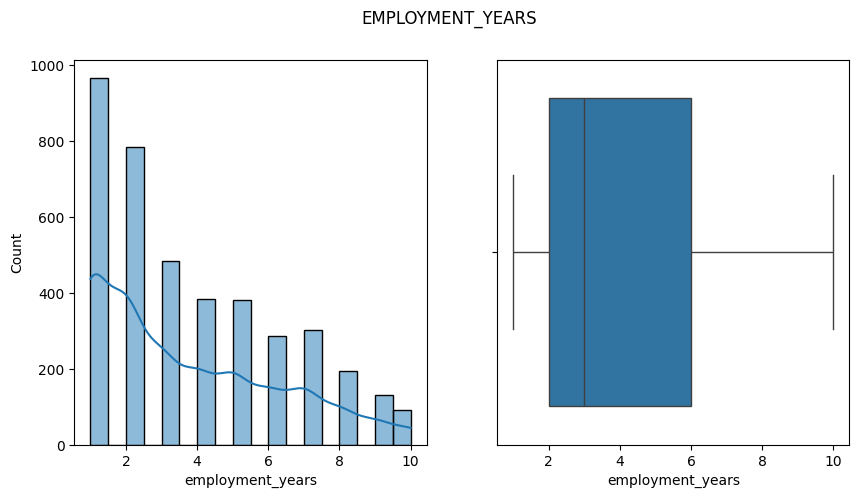

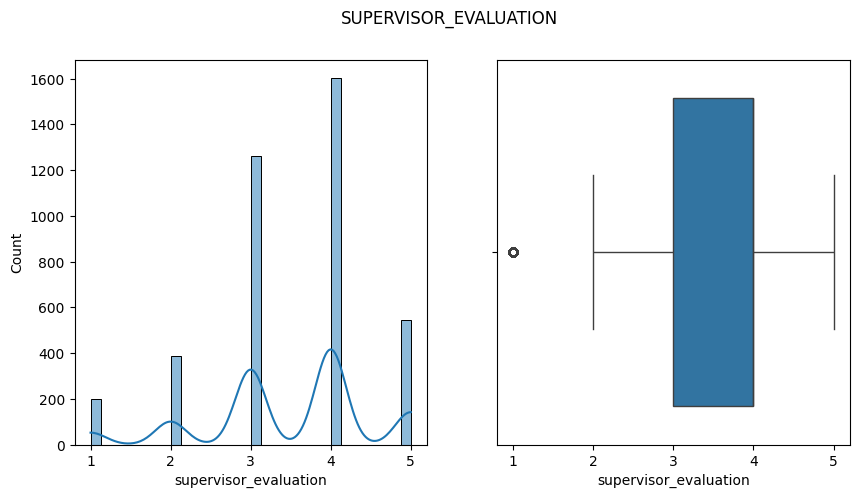

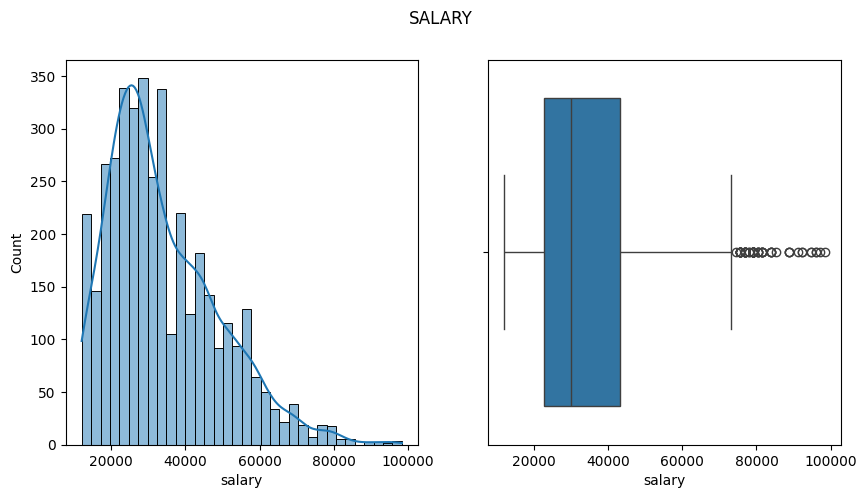

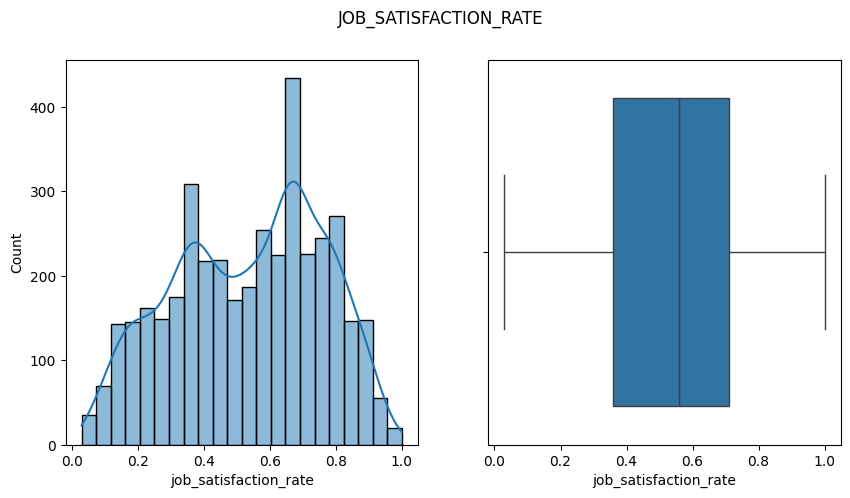

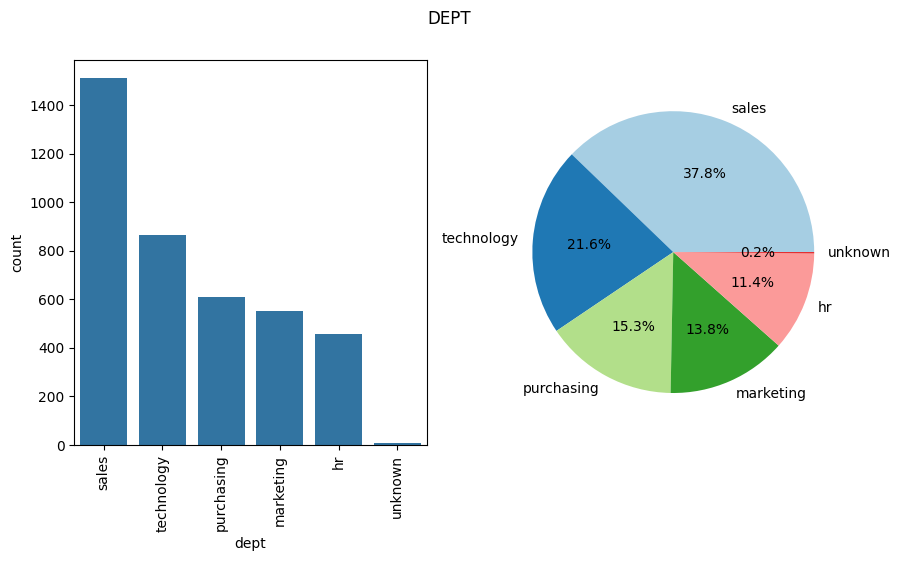

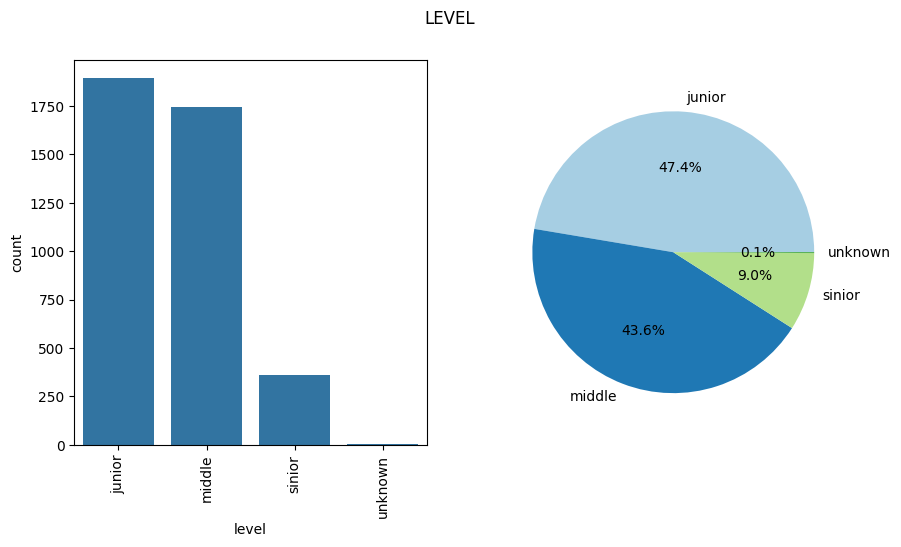

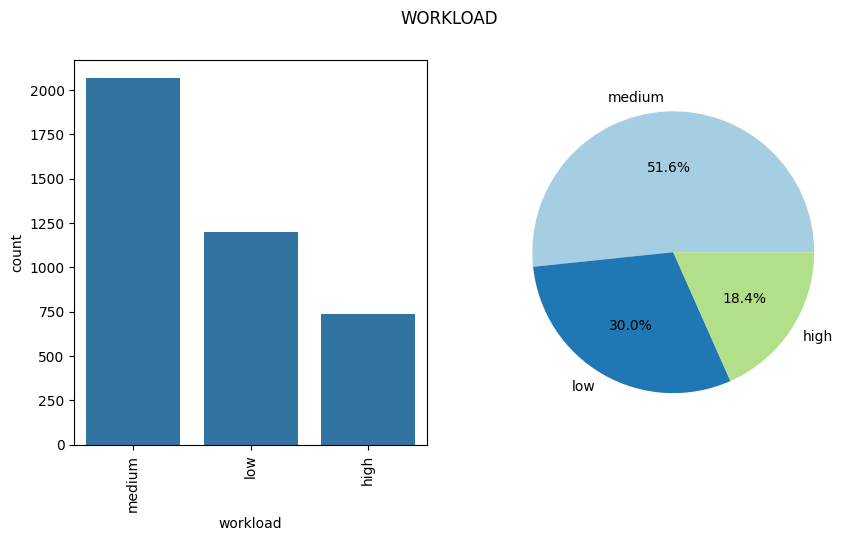

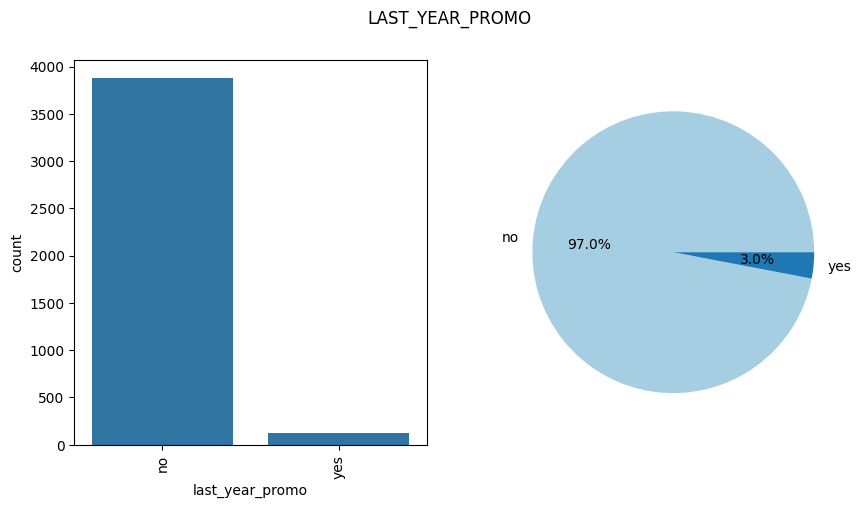

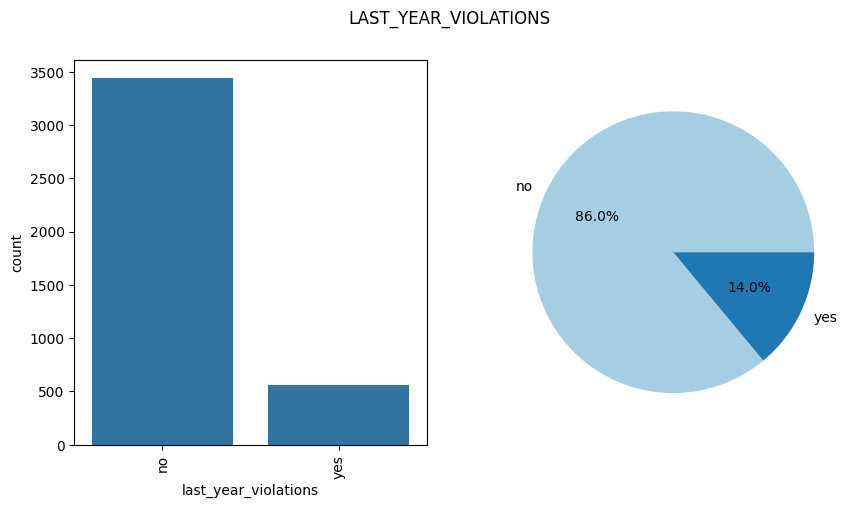

In [16]:
hist_box_pie(train_job_satisfaction_rate)

В этом фрейме выглядит вссе логично. Какие выводы можно сделаать:
- половина сотрудинков трудятся в компании от 2 до 6 лет. Среднее значение - 3 года.
- средняя оценка качества работы сотрудников - 3-4 балла.
- средняя зарплата 30 тыс руб. Половина сотрудников получают зарплату от 20 до 45 тыс. руб.
- ВНИМАНИЕ! Есть выбросы - с показателями высокой зарплаты. 
- средний уровень удовлетворенноссти работой - 0.4 - 0.7.
- распределение по департаментам  в порядке уменьшения: продажи, технологии, закупки, маркетинг, hr
- уровни занимаемой должноссти в порядке убывания: junior, middle, sinior
- уровни загруженности в порядке уменьшения: средняя, низкая, высокая
- повышение за последний год было у 3% сотрудников.
- нарушения за последний год совершили 14% сотрудников

Исследуем следующий фрейм

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.00,2000,2000,2000,2000.00,2000,2000,2000.00,2000.00
unique,NaN,7,4,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.21,NaN,NaN,NaN,3.67,NaN,NaN,3.53,34066.80
std,253851.33,NaN,NaN,NaN,2.54,NaN,NaN,1.00,15398.44
min,100298.00,NaN,NaN,NaN,1.00,NaN,NaN,1.00,12000.00
25%,339052.00,NaN,NaN,NaN,1.00,NaN,NaN,3.00,22800.00
50%,550793.00,NaN,NaN,NaN,3.00,NaN,NaN,4.00,30000.00
75%,765763.75,NaN,NaN,NaN,6.00,NaN,NaN,4.00,43200.00


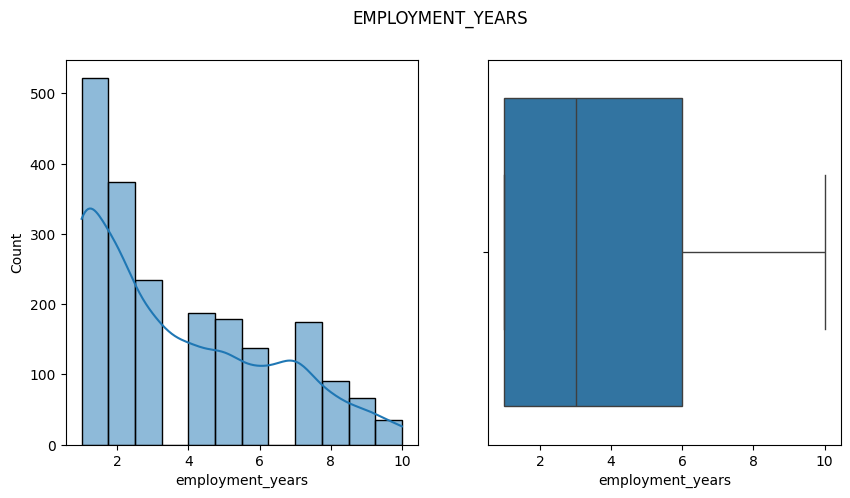

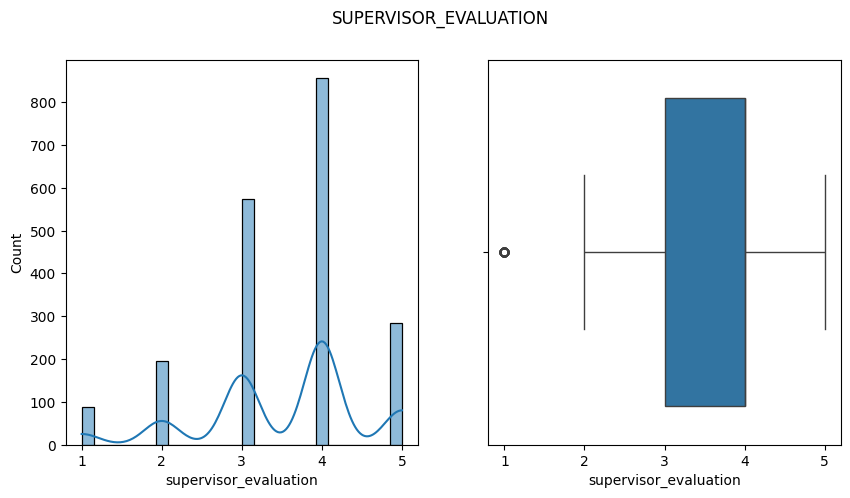

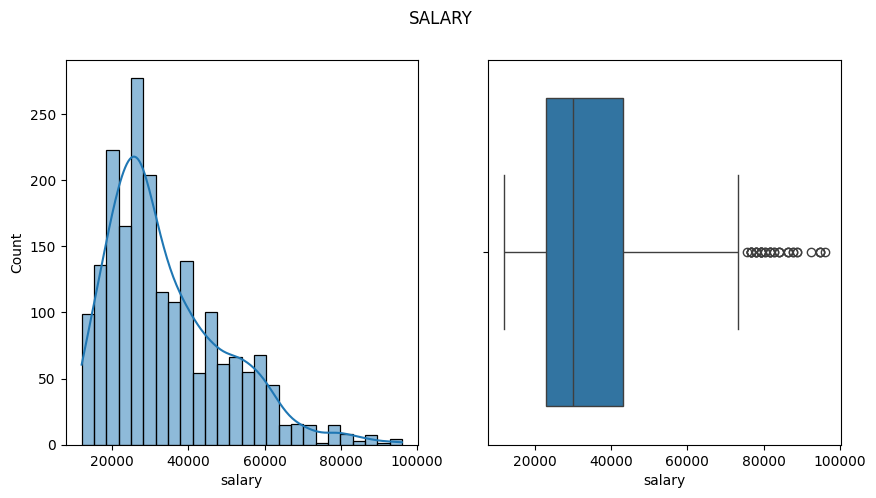

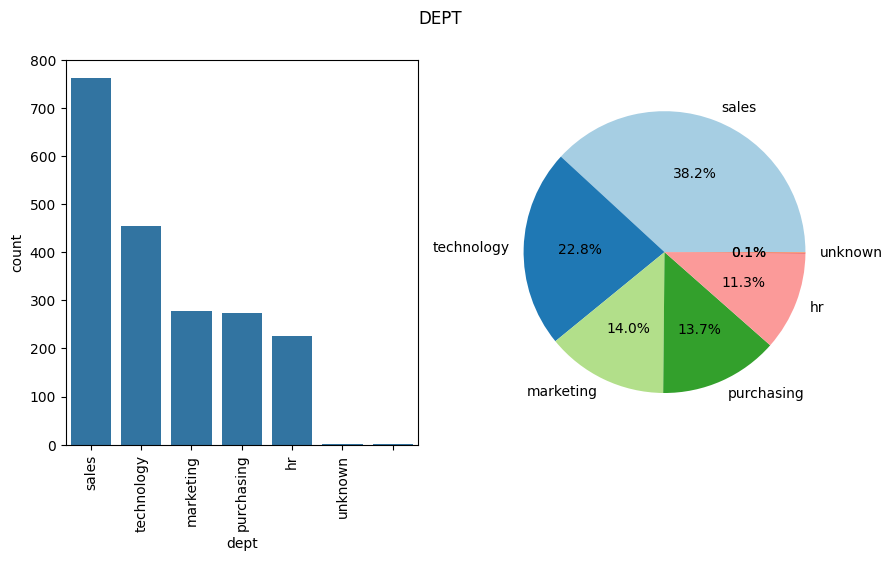

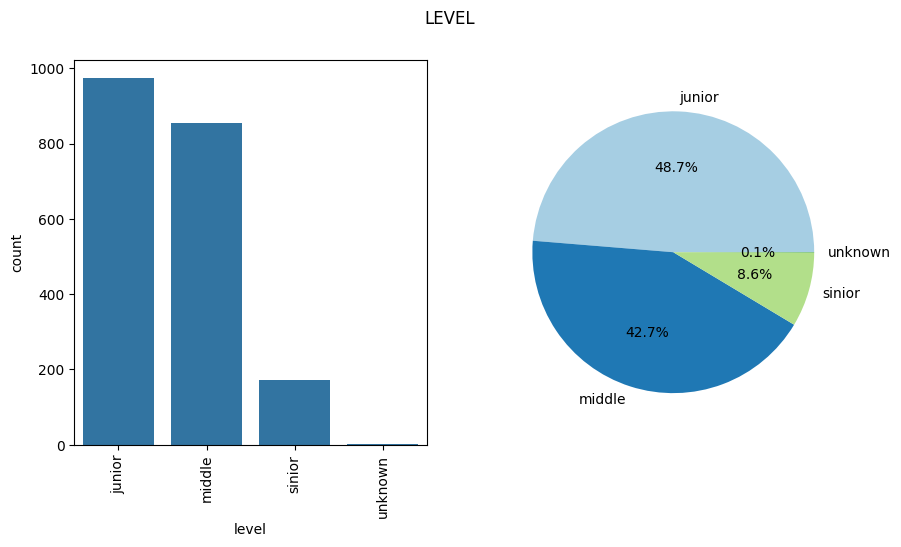

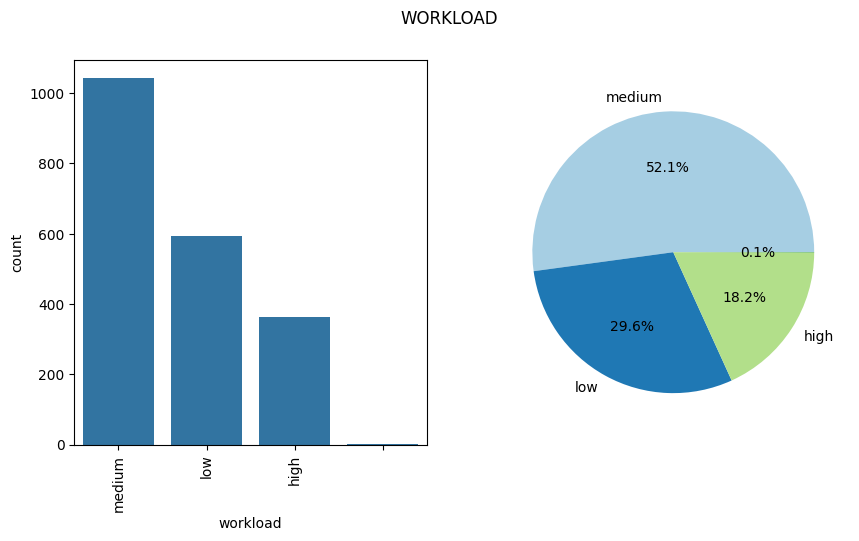

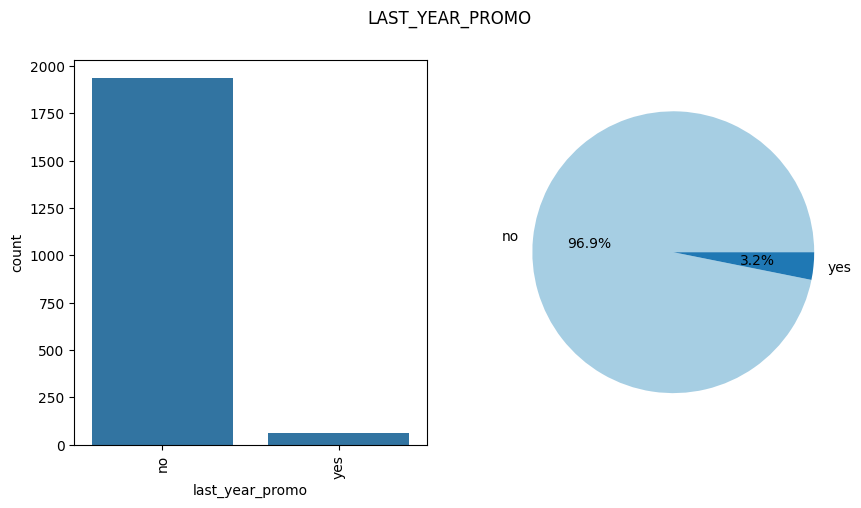

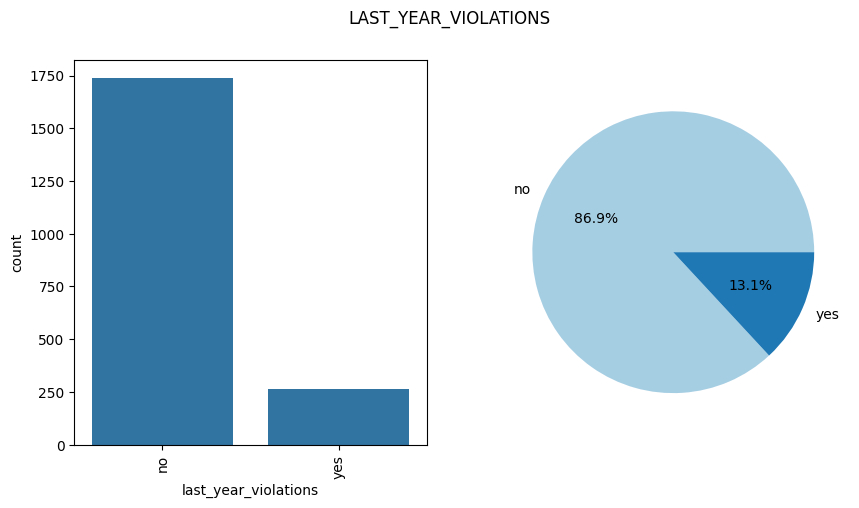

In [17]:
hist_box_pie(test_features)

Анализируем:
- среднее время работы в компании - 3 года
- средняя оценка качества работы - 3 - 4
- зарплата от 20 до 45 тыс. руб. Так же есть выбросы на значениях зарплаты более 75 тыс. руб.
- распределениеи по департаментам - немного другое: в маркетинге чуть больше чем в закупках трудятся
- уровень сотрудников - похоже
- загруженность - похоже
- повышений - похоже
- нарушений - похоже

,id,job_satisfaction_rate
count,2000.00,2000.00
mean,552765.21,0.55
std,253851.33,0.22
min,100298.00,0.03
25%,339052.00,0.38
50%,550793.00,0.58
75%,765763.75,0.72
max,999029.00,1.00


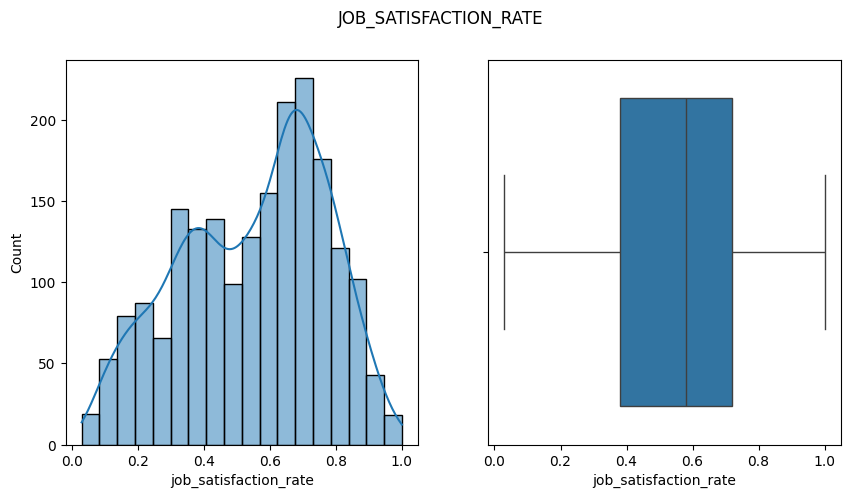

In [18]:
hist_box_pie(test_target_job_satisfaction_rate)

В целевом тестовом признаке аномалий нет. Удовлетворенность средняя от 0.4 до 0.7

Выводы.

В результате исследовательского анализа данных были сделаны следующие выводы:

train_job_satisfaction_rate:
- половина сотрудинков трудятся в компании от 2 до 6 леет. Среднее значение - 3 года.
- средняя оценка качества работы сотрудников - 3-4 балла.
- средняя зарплата 30 тыс руб. Половина сотрудников получают зарплату от 20 до 45 тыс. руб.
- ВНИМАНИЕ! Есть выбросы - с показателями высокой зарплаты. будем убирать?
- средний уровень удовлетворенноссти работой - 0.4 - 0.7.
- распределение по департаментам  в порядке уменьшения: продажи, технологии, закупки, маркетинг, hr
- уровни занимаемой должноссти в порядке убывания: junior, middle, sinior
- уровни загруженности в порядке уменьшения: средняя, низкая, высокая
- повышение за последний год было у 3% сотрудников.
- нарушения за последний год совершили 14% сотрудников

test_features:
- среднее время аботы в компании - 3 года
- средняя оценка качества работы - 3 - 4
- зарплата от 20 до 45 тыс. руб. Так же есть выбросы на значениях зарплаты более 75 тыс. руб.
- распределениеи по департаментам - немного другое: в маркетинге чуть больше чем в закупках трудятся
- уровень сотрудников - похоже
- загруженность - похоже
- повышений - похоже
- нарушений - похоже

test_target_job_satisfaction_rate:
- В целевом тестовом признаке аномалий нет. Удовлетворенность средняя от 0.4 до 0.7

Данные в тренировочном и тестовых данных похожи. их можно использовать для дальнейшего исследования.

Выводы.

В результате исследовательского анализа данных были сделаны следующие выводы:

train_job_satisfaction_rate:
- половина сотрудников трудятся в компании от 2 до 6 леет. Среднее значение - 3 года.
- средняя оценка качества работы сотрудников - 3-4 балла.
- средняя зарплата 30 тыс руб. Половина сотрудников получают зарплату от 20 до 45 тыс. руб.
- ВНИМАНИЕ! Есть выбросы - с показателями высокой зарплаты. будем убирать?
- средний уровень удовлетворенноссти работой - 0.4 - 0.7.
- распределение по департаментам  в порядке уменьшения: продажи, технологии, закупки, маркетинг, hr
- уровни занимаемой должноссти в порядке убывания: junior, middle, sinior
- уровни загруженности в порядке уменьшения: средняя, низкая, высокая
- повышение за последний год было у 3% сотрудников.
- нарушения за последний год совершили 14% сотрудников

test_features:
- среднее время аботы в компании - 3 года
- средняя оценка качества работы - 3 - 4
- зарплата от 20 до 45 тыс. руб. Так же есть выбросы на значениях зарплаты более 75 тыс. руб.
- распределениеи по департаментам - немного другое: в маркетинге чуть больше чем в закупках трудятся
- уровень сотрудников - похоже
- загруженность - похоже
- повышений - похоже
- нарушений - похоже

test_target_job_satisfaction_rate:
- В целевом тестовом признаке аномалий нет. Удовлетворенность средняя от 0.4 до 0.7

Данные в тренировочном и тестовых данных похожи. их можно использовать для дальнейшего исследования.

### Исследование корреляции признаков
Проведем иссследование кокрреляции признаков - phik-корреляцию.

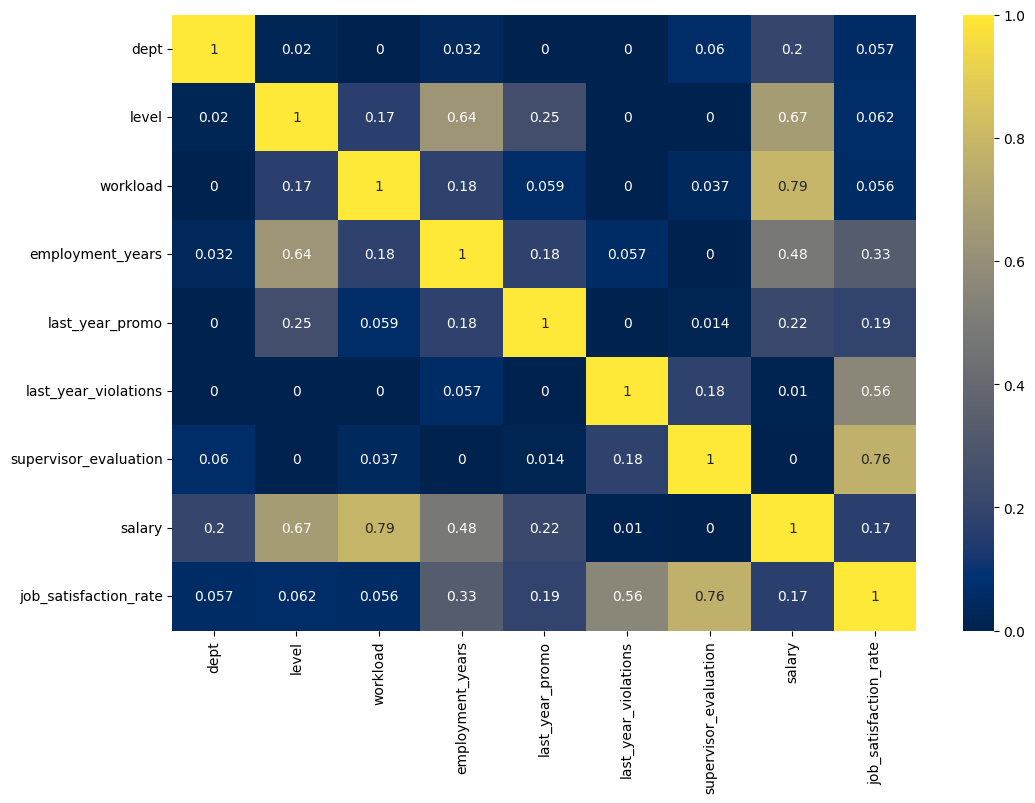

In [19]:
num_cols = train_job_satisfaction_rate.select_dtypes(include='number').columns.drop('id').tolist()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(train_job_satisfaction_rate.drop(columns=['id']).phik_matrix(interval_cols=num_cols,) , annot=True, cmap='cividis');
plt.show()

Видны высокие значения корреляции между входящими признаками зарплата - уровень загруженности, оценка качества работы сотрудника - уровень удовлетворенноссти сотрудника. Но они не превышают значение 0.9, когда очень высокая корреляция могла бы мешать нахождению зависимостей между моделями.

Так же построим корреляцию Спирмена (в виу того, что распределение числовых данных  не носит нормальный характер) только для числовых данных.

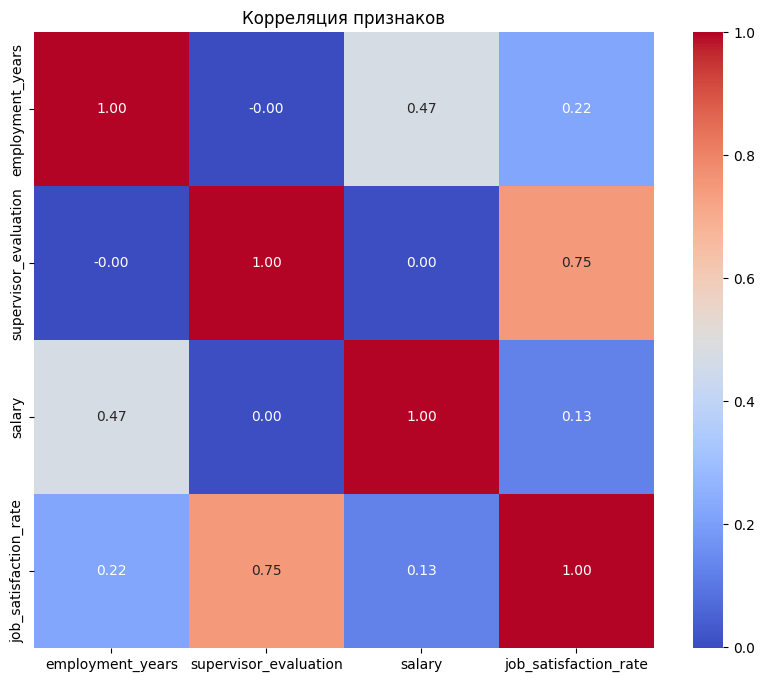

In [20]:
num_cols = train_job_satisfaction_rate.select_dtypes(include='number').columns.drop('id').tolist()
plt.figure(figsize=(10,8))

fig = sns.heatmap(train_job_satisfaction_rate[[*num_cols]].corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
fig.set_title('Корреляция признаков')
plt.show()

## Подготовка данных
Готовим данные исходных датасетов. Разбиваем данные на тртенировочные и валидационные

In [21]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

Объединяем данные для тестовой выборки и проверяем чтобы не было пропусков в данных

In [22]:
df_test = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')
df_test.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [23]:
X_test = df_test.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = df_test['job_satisfaction_rate']

Кодируем категориальные признаки и скалируем числовые с помощью пайплайна. Сортируем колонки по спискам.

In [24]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [25]:
simp_imp_pipe = Pipeline([('simp_imp', SimpleImputer(strategy='constant', fill_value='unknown',)), ])

In [26]:
ohe_pipe = Pipeline([
    ('simp_imp_ohe', SimpleImputer(strategy='constant', fill_value='unknown',)),
#     ('simp_imp_ohe', SimpleImputer(strategy='most_frequent', missing_values=np.nan,)),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])
ord_pipe = Pipeline([
    ('simp_imp_before_ord', SimpleImputer(strategy='most_frequent', missing_values=np.nan,)),
#     ('simp_imp_before_ord', SimpleImputer(strategy='constant', fill_value='unknown',)),
    ('ord', OrdinalEncoder(
        categories = [
#             ['junior', 'middle', 'sinior', 'unknown'],
#             ['low', 'medium', 'high', 'unknown'],
            ['junior', 'middle', 'sinior', ],
            ['low', 'medium', 'high', ],
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simp_imp_after_ord', SimpleImputer(strategy='most_frequent', missing_values=np.nan,)),
#     ('simp_imp_after_ord', SimpleImputer(strategy='constant', fill_value='unknown',)),
])

In [27]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

## Обучаем модели
С помощью pipeline обучаем несколько разных моделей с подбором параметров и выбираем по итогам лучшую.

Сперва готовим pipeline.

In [28]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
]) 

In [29]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,12),
        'models__min_samples_split': range(1,12),
        'models__min_samples_leaf': range(1,12),
        'models__max_features': range(1,12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },    
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': ['0.1, 0.5, 1, 5, 10'],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },    
]

Делаем свою метрику

In [30]:
def smape(real, pred):
    '''
    Вычислением метрики SMAPE (англ. symmetric mean absolute percentage error, 
    «симметричное среднее абсолютное процентное отклонение»). 
    '''
    return (100/len(real) * np.sum(
        2 * np.abs(real-pred) /
        (np.abs(real) + np.abs(pred))
    )
)
smape_score = make_scorer(smape, greater_is_better=False)

Обучаем модель


In [31]:
grid = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=smape_score,
    # scoring='roc_auc',
    n_jobs=-1,
    n_iter=300
)

grid.fit(X_train, y_train)

print('Лучшая модель и параметры:', grid.best_estimator_['models'])
print('Метрика лучшей модели:', grid.best_score_)

Лучшая модель и параметры: DecisionTreeRegressor(max_depth=11, max_features=11, min_samples_leaf=4,
                      min_samples_split=11, random_state=42)
Метрика лучшей модели: -15.146523503791183


Лучшая модель и лучшая метрика:
- DecisionTreeRegressor(max_depth=11, max_features=11, min_samples_leaf=4, min_samples_split=11)
- -15.15

In [32]:
y_test_pred = grid.predict(X_test)
print('Значение метрики на тестовой выборке: ', smape(y_test, y_test_pred))

Значение метрики на тестовой выборке:  14.195913858322406


Значение метрики на тестовой выборке - 14.2.

## Изучаем степень влиния входящих признаков на целевой показатель

In [33]:
shap.plots.initjs()

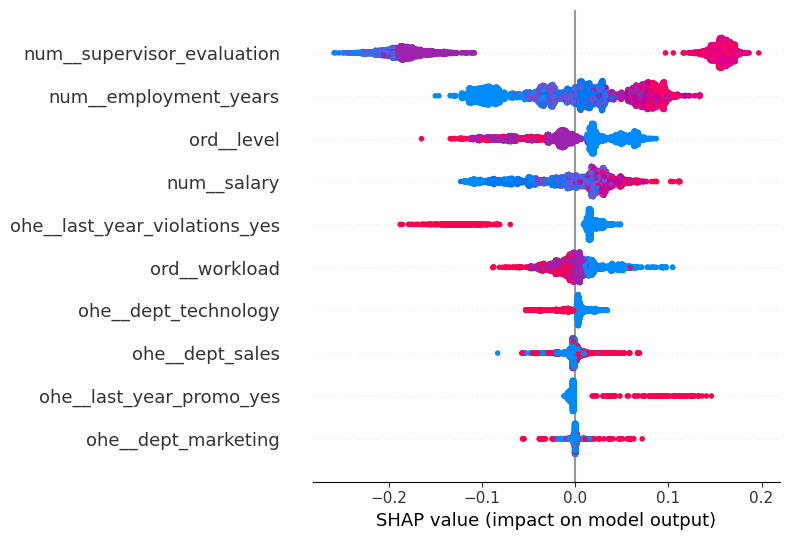

In [34]:
best_model = grid.best_estimator_
data = pd.DataFrame(
    best_model['preprocessor'].transform(X_train),
    columns=best_model['preprocessor'].get_feature_names_out()
)

shap_values = shap.TreeExplainer(best_model['models']).shap_values(data)
shap.summary_plot(shap_values, data, max_display=10, show=True, color_bar=False, auto_size_plot=True)

Попробуем улучшить метрику с помощью удаления выбросов у колонки salary

In [35]:
def outliers_delete_iqr(df, col):
    '''
    Удаление значений за пределами 1,5 * IQR.
    Аргументы: датафрейм и колонка данных.
    '''
    q_low = df[col].quantile(0.25)
    q_hi  = df[col].quantile(0.75)
    iqr = q_hi - q_low
    df_filtered = df[(df[col] < q_hi+1.5*iqr) & (df[col] > q_low-1.5*iqr)]
    return df_filtered

Применяем к колонке зарплата

In [36]:
train_job_satisfaction_rate_2 = outliers_delete_iqr(train_job_satisfaction_rate, 'salary')

In [37]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

In [38]:
grid_2 = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    random_state=RANDOM_STATE,
    scoring=smape_score,
    n_jobs=-1,
    n_iter=300
)

grid_2.fit(X_train, y_train)

print('Лучшая модель и параметры:', grid_2.best_estimator_['models'])
print('Метрика лучшей модели:', grid_2.best_score_)

Лучшая модель и параметры: DecisionTreeRegressor(max_depth=11, max_features=11, min_samples_leaf=4,
                      min_samples_split=11, random_state=42)
Метрика лучшей модели: -15.146523503791183


In [39]:
y_test_pred = grid_2.predict(X_test)
print('Значение метрики на тестовой выборке: ', smape(y_test, y_test_pred))

Значение метрики на тестовой выборке:  14.195913858322406


Значение скорректированной метрики: 14.196 - на уровне предыдущей.

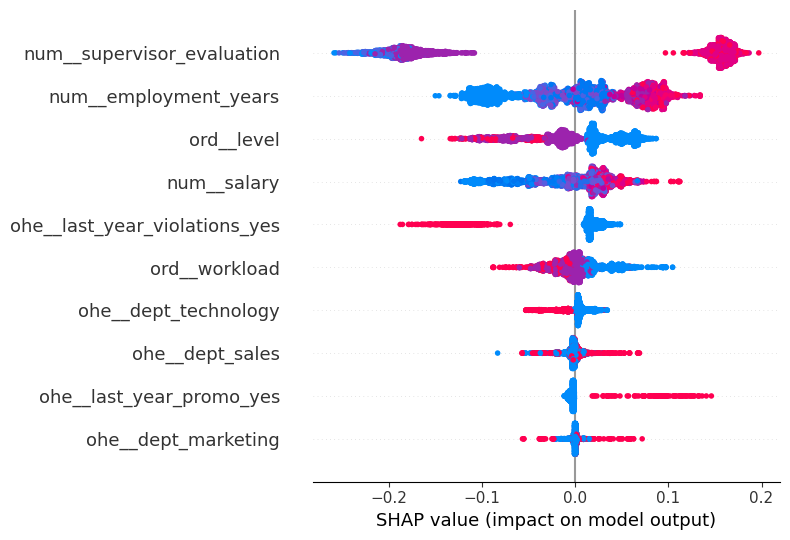

In [40]:
best_model = grid_2.best_estimator_
data = pd.DataFrame(
    best_model['preprocessor'].transform(X_train),
    columns=best_model['preprocessor'].get_feature_names_out()
)

shap_values = shap.TreeExplainer(best_model['models']).shap_values(data)
shap.summary_plot(shap_values, data, max_display=10, show=True, color_bar=False, auto_size_plot=True)

 ## Промежуточный вывод. 
При удалении выбросов по зарплате - качество модели при проверке по тестовой выборке не изменилось. Следовательно лучшая модель хорошо справляется с данными вне зависимости от выбросов.
С предсказанием лучше справилась "деревянная" модель. Лучшая модель (с параметрами) и лучшая метрика:
- DecisionTreeRegressor(max_depth=11, max_features=11, min_samples_leaf=4, min_samples_split=11)
- -14.2

Наиболее сильно на предсказание влияют в порядке уменьшения следующие признаки:
- оценка качества работы сотрудников руководителем,
- длительность работы в компании,
- зарплата,
- фактор нарушения договора сотрудником в прошлом году,
- уровень занимаемой должности.

# Предсказание увольнения сотрудника из компании


## Загрузка данных
- Тренировочная выборка: train_quit.csv
- Входные признаки тестовой выборки те же, что и в прошлой задаче: test_features.csv
- Целевой признак тестовой выборки: test_target_quit.csv

In [41]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

Загружаем, проверяем

In [42]:
display(train_quit.head())
display(test_features.head())
display(test_target_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [43]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Данные загружены корректно. Пропуски отсутствуют.

In [44]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Данные загружены корректно - 2000 строк. Есть пропуски в колонках dept и level. Обработаем их далее.

In [45]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Данные загружены корректно. 2000 строк. В данных пропусков нет. 

В результате первичной проверки данных убедились, что они загружены корректно, в одной таблице отсутствуют значения в нескольких записях, что требует в дальнейшем допольнительной обработки.

## Предобработка данных
Изучаем датафреймы.

In [46]:
descr(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
Тип данных,int64,object,object,object,int64,object,object,int64,int64,object
Количество строк,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
Строк без пропусков,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
Количество пропусков,0,0,0,0,0,0,0,0,0,0
"Пропуски, %",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Количество уникальных,4000,5,3,3,10,2,2,5,69,2
Минимум,100222,-,-,-,1,-,-,1,12000,-
Максимум,999915,-,-,-,10,-,-,5,96000,-
Количество дубликатов,0,3995,3997,3997,3990,3998,3998,3995,3931,3998
Сэмпл,"[100222, 100459, 100469, 100601, 100858, 10096...","[hr, marketing, purchasing, sales, technology]","[junior, middle, sinior]","[high, low, medium]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[no, yes]","[no, yes]","[1, 2, 3, 4, 5]","[12000, 13200, 14400, 15600, 16800, 18000, 192...","[no, yes]"


train_quit - пропусков нет

In [47]:
descr(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
Тип данных,int64,object,object,object,int64,object,object,int64,int64
Количество строк,2000,2000,2000,2000,2000,2000,2000,2000,2000
Строк без пропусков,2000,1998,1999,2000,2000,2000,2000,2000,2000
Количество пропусков,0,2,1,0,0,0,0,0,0
"Пропуски, %",0.00,0.10,0.05,0.00,0.00,0.00,0.00,0.00,0.00
Количество уникальных,2000,6,3,4,10,2,2,5,66
Минимум,100298,-,-,-,1,-,-,1,12000
Максимум,999029,-,-,-,10,-,-,5,96000
Количество дубликатов,0,1993,1996,1996,1990,1998,1998,1995,1934
Сэмпл,"[100298, 100480, 100503, 100610, 100692, 10071...","[ , hr, marketing, purchasing, sales, technolo...","[junior, middle, sinior, nan]","[ , high, low, medium]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[no, yes]","[no, yes]","[1, 2, 3, 4, 5]","[12000, 13200, 14400, 15600, 16800, 18000, 192..."


test_features - есть пропуски в колонках dept и level. Заполняем с помощью пайплайна - на пропущенных строках поставим заглушку и проверяем на отсутствие пропусков.



In [48]:
simp_imp_pipe = Pipeline([('simp_imp', SimpleImputer(strategy='constant', fill_value='unknown',)), ])

test_features[['dept', 'level']] = simp_imp_pipe.fit_transform(test_features[['dept', 'level']])
test_features.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [49]:
descr(test_target_quit)

,id,quit
Тип данных,int64,object
Количество строк,2000,2000
Строк без пропусков,2000,2000
Количество пропусков,0,0
"Пропуски, %",0.00,0.00
Количество уникальных,2000,2
Минимум,100298,-
Максимум,999029,-
Количество дубликатов,0,1998
Сэмпл,"[100298, 100480, 100503, 100610, 100692, 10071...","[no, yes]"


test_target_quit - пропусков нет

Предобраотка данных проведена, в данных с пропусками поставлены "заглушки".


## Исследовательский анализ данных


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000.00,4000,4000,4000,4000.00,4000,4000,4000.00,4000.00,4000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,2
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,NaN,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,552099.28,NaN,NaN,NaN,3.70,NaN,NaN,3.47,33805.80,NaN
std,260158.03,NaN,NaN,NaN,2.54,NaN,NaN,1.00,15152.42,NaN
min,100222.00,NaN,NaN,NaN,1.00,NaN,NaN,1.00,12000.00,NaN
25%,327785.75,NaN,NaN,NaN,2.00,NaN,NaN,3.00,22800.00,NaN
50%,546673.00,NaN,NaN,NaN,3.00,NaN,NaN,4.00,30000.00,NaN
75%,781497.75,NaN,NaN,NaN,6.00,NaN,NaN,4.00,43200.00,NaN


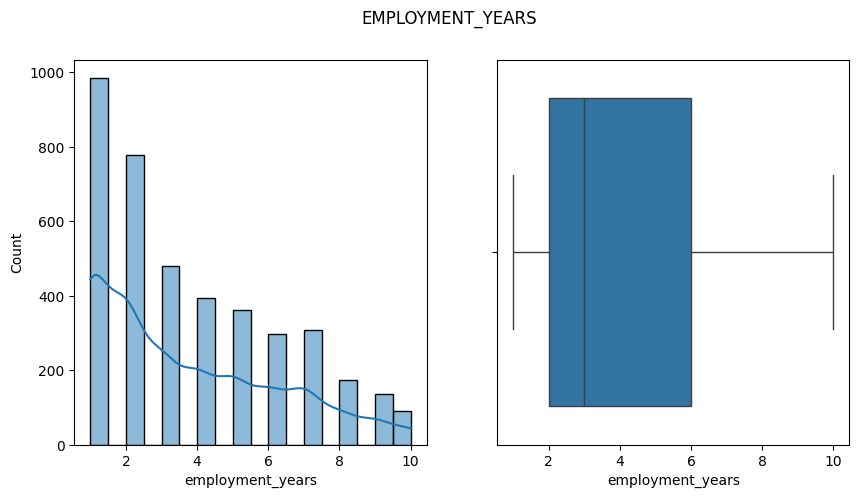

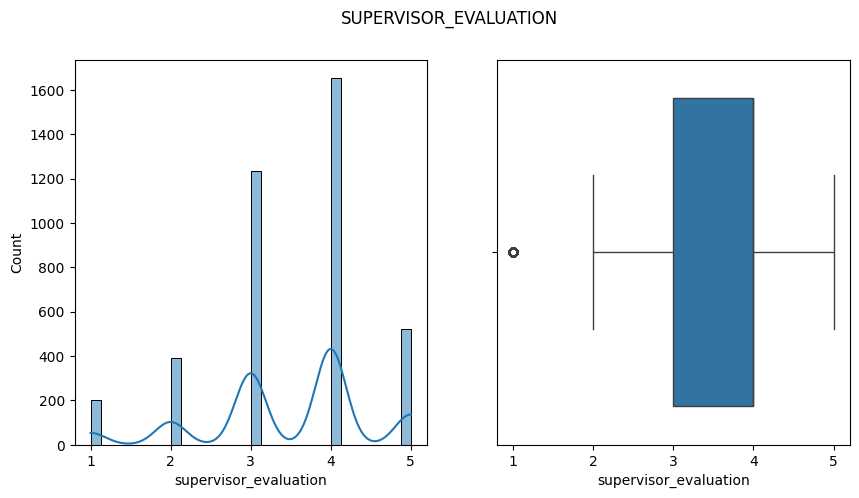

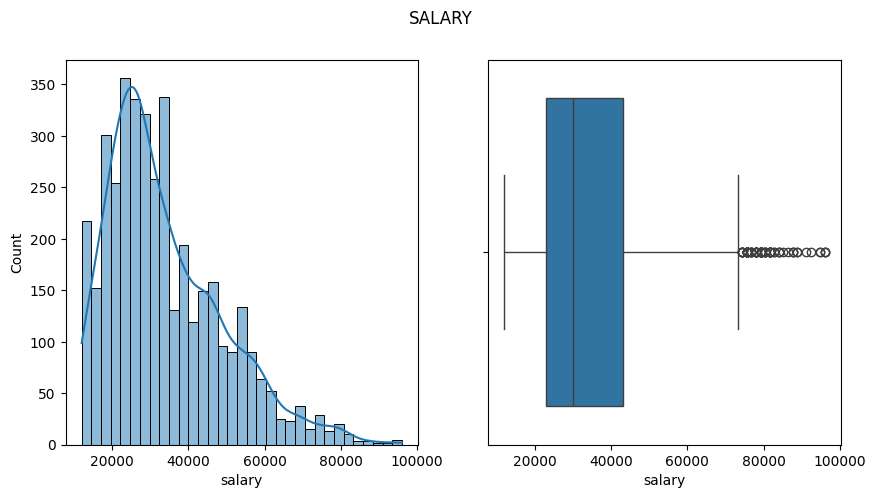

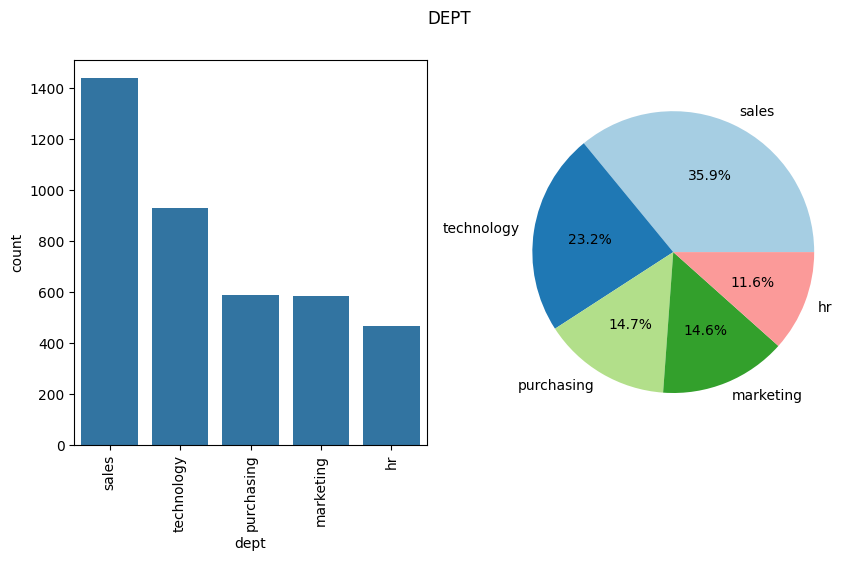

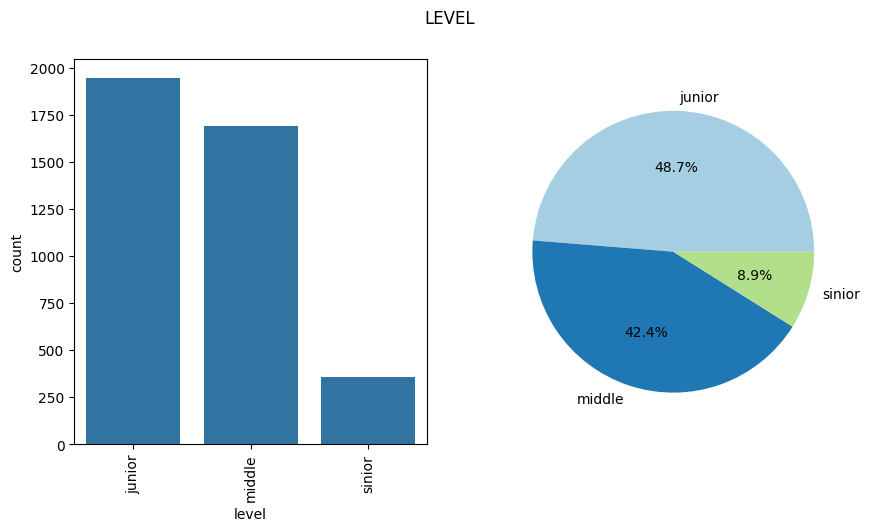

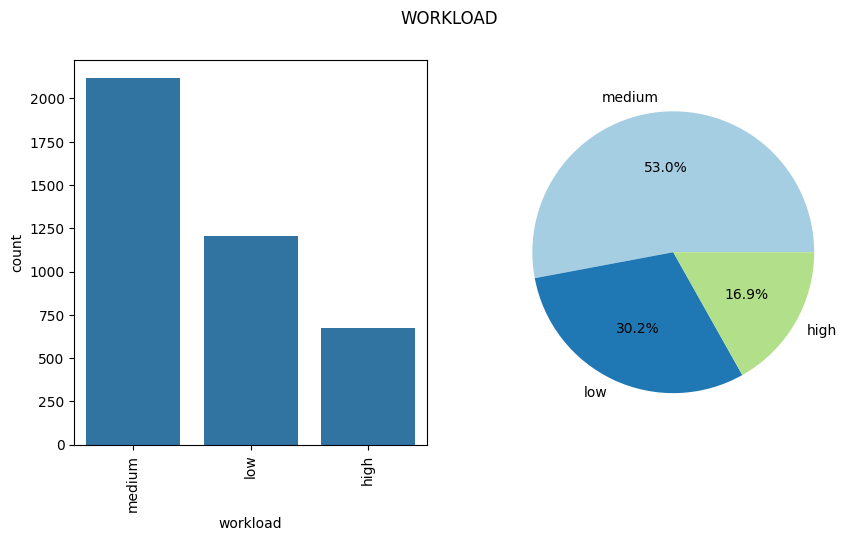

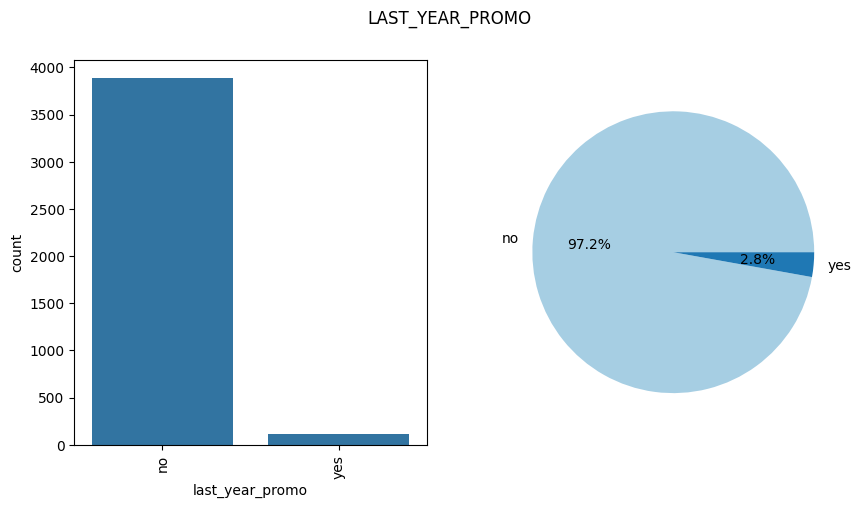

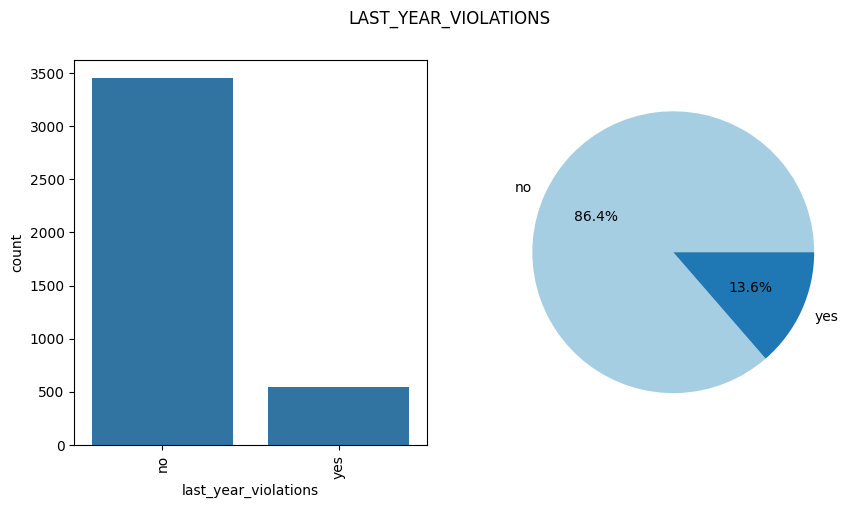

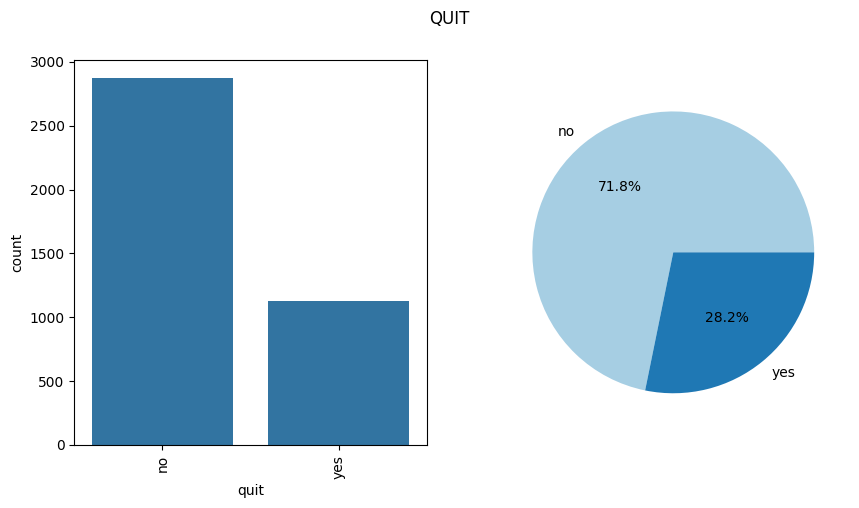

In [50]:
hist_box_pie(train_quit)

Выводы:

- В тренировочной выборке 28% уволились.

### Составляем портрет уволившихся сотрудников.
Поиск закономерностей.

In [51]:
df_quit = train_quit[train_quit.quit=='yes']
df_no_quit = train_quit[train_quit.quit!='yes']
df_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


Зарплаты и уровни загруженности уволившихся сотрудников по департаментам

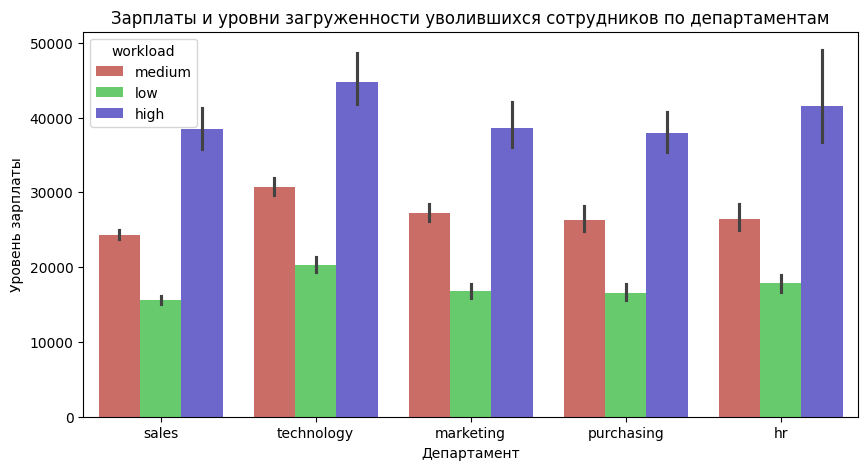

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='dept', y='salary', data=df_quit, hue='workload', palette='hls');
ax.set_title('Зарплаты и уровни загруженности уволившихся сотрудников по департаментам')
ax.set_xlabel('Департамент')
ax.set_ylabel('Уровень зарплаты')
plt.show()

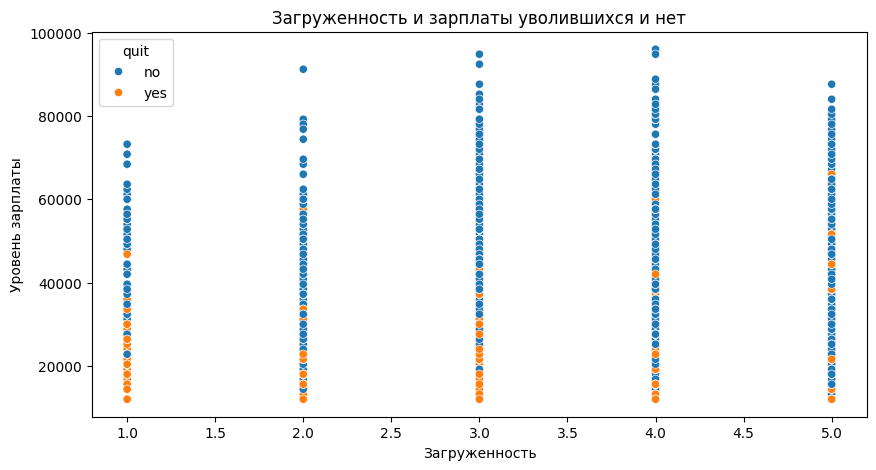

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
ax=sns.scatterplot(data=train_quit, x="supervisor_evaluation", y="salary", hue='quit');
ax.set_title('Загруженность и зарплаты уволившихся и нет')
ax.set_xlabel('Загруженность')
ax.set_ylabel('Уровень зарплаты')
plt.show()

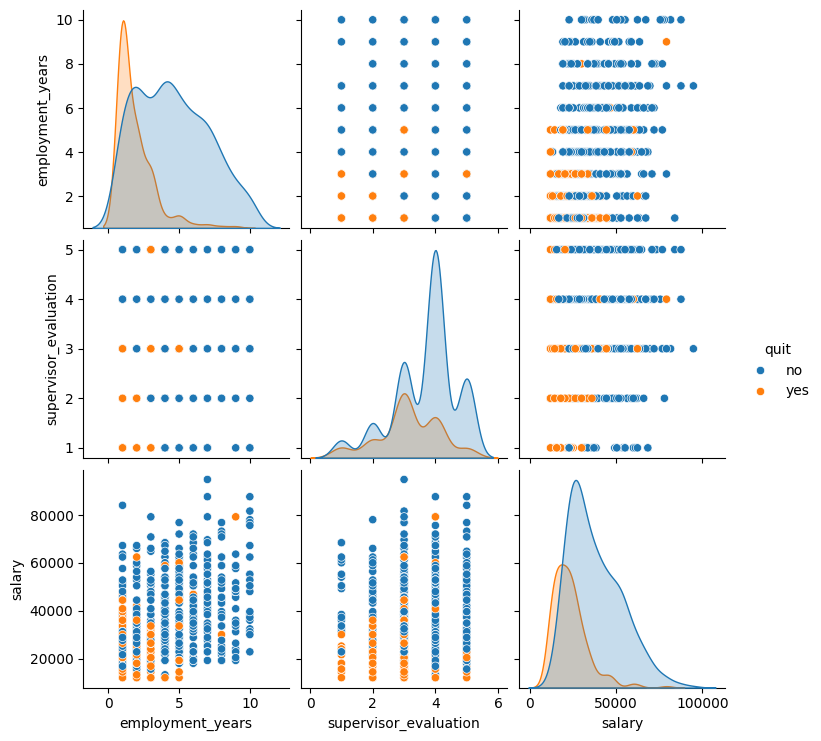

In [54]:
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']
sns.pairplot(train_quit[[*num_cols, 'dept', 'quit']].sample(frac=0.2, random_state=RANDOM_STATE), hue='quit')
plt.show()

In [55]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


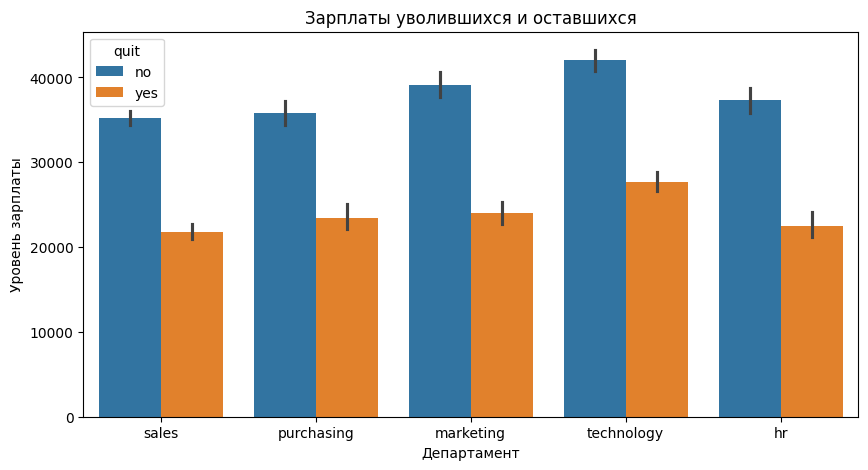

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=train_quit, x='dept', y='salary', hue='quit');
ax.set_title('Зарплаты уволившихся и оставшихся')
ax.set_xlabel('Департамент')
ax.set_ylabel('Уровень зарплаты')
plt.show()

Различия между уволившимися и не уволовшимися:
- Уволившиеся проработали в компании меньше, получали меньше, оценка качества работы ниже

In [57]:
quit_table = train_quit.pivot_table(index='dept', columns='quit', values='id', aggfunc=['count']).reset_index()
quit_table
quit_table['sum'] = quit_table['count']['no'] + quit_table['count']['yes']
quit_table['rate'] = 100 * quit_table['count']['yes'] / (quit_table['count']['no'] + quit_table['count']['yes'])
quit_table.columns = ['dept', 'stay', 'quit', 'sum', 'rate_%']
quit_table

,dept,stay,quit,sum,rate_%
0,hr,348,116,464,25.00
1,marketing,419,163,582,28.01
2,purchasing,422,166,588,28.23
3,sales,1031,407,1438,28.30
4,technology,652,276,928,29.74


- В отделе РК работают 464 сотрудника, 116 уволилось (25%), 
- отдел маркетинга - 582, уволилось 163 (28%),
- закупки - 588, уволилось 166 (28%),
- продажи - 1438, уволилось 407 (28%),
технологии - 928, уволилось 276 (30%).

### Проверяем гипотезу зависимости уровня удовлетворенности и факта увольнения.

In [58]:
extracted_column = test_target_job_satisfaction_rate[['id', 'job_satisfaction_rate']]
satisfaction_df = pd.merge(test_target_quit, extracted_column, on='id', how='left')

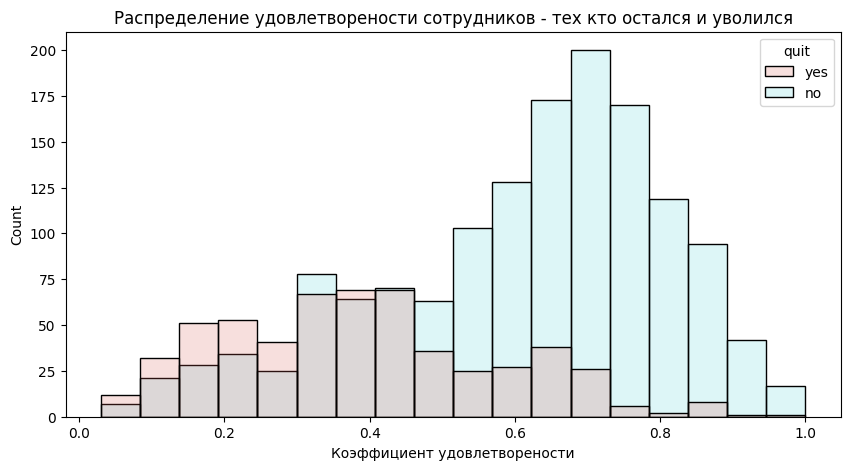

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.histplot(x='job_satisfaction_rate', data=satisfaction_df, hue='quit', palette='hls', alpha=0.2);
ax.set_title('Распределение удовлетворености сотрудников - тех кто остался и уволился')
ax.set_xlabel('Коэффициент удовлетворености')
plt.show()

Действительно, есть визуальные отличия в удовлетворенности работой у уволившихся и оставшихся работать сотрудников. 

Для проверки различий в выборках применим статистический тест. Узнаем наличие  соответствия в оценке статистической значимости.

Формулируем нулевую гипотезу H0: - средние значения выборок удовлетворенности равны. H1 -средние выборок не равны.
Применяем двусторонний тест для двух разных выборок. Альфа=0.05

In [60]:
quit_no = satisfaction_df[satisfaction_df['quit']=='no']['job_satisfaction_rate']
quit_yes = satisfaction_df[satisfaction_df['quit']=='yes']['job_satisfaction_rate']

In [61]:
alpha = 0.05
results = st.ttest_ind(quit_no, quit_yes, equal_var=False, alternative='two-sided')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('< alpha: Отвергаем нулевую гипотезу')
else:
    print('> alpha:  Не отвергаем нулеву гипотезу')

p-value: 2.770862803154374e-101
< alpha: Отвергаем нулевую гипотезу


Вывод: отвергаем нулевую гипотезу о равенстве средних выборок. Есть основания утверждать, что показатели удовлетворенности работой у оставшихся и уволившихся сотрудников статистически различаются.

## Регрессионный анализ
job_satisfaction_rate и quit действительно связаны. Добавим job_satisfaction_rate, предсказанный лучшей моделью к входным признакам второй задачи.

Применяем лучшую модель регрессии признака удовлетворенности работой к новому датасету train_quit. Создаем новый датасет train_quit_satisfaction

In [62]:
y_pred = grid.predict(train_quit)

train_quit_satisfaction = train_quit.copy()
train_quit_satisfaction['job_satisfaction_predict'] = y_pred
train_quit_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_predict
0,723290,sales,middle,high,2,no,no,4,54000,no,0.64
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.83
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.37
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.33
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.82


In [63]:
descr(train_quit_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_predict
Тип данных,int64,object,object,object,int64,object,object,int64,int64,object,float64
Количество строк,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
Строк без пропусков,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
Количество пропусков,0,0,0,0,0,0,0,0,0,0,0
"Пропуски, %",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Количество уникальных,4000,5,3,3,10,2,2,5,69,2,333
Минимум,100222,-,-,-,1,-,-,1,12000,-,0.06
Максимум,999915,-,-,-,10,-,-,5,96000,-,0.98
Количество дубликатов,0,3995,3997,3997,3990,3998,3998,3995,3931,3998,3667
Сэмпл,"[100222, 100459, 100469, 100601, 100858, 10096...","[hr, marketing, purchasing, sales, technology]","[junior, middle, sinior]","[high, low, medium]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[no, yes]","[no, yes]","[1, 2, 3, 4, 5]","[12000, 13200, 14400, 15600, 16800, 18000, 192...","[no, yes]","[0.06000000000000001, 0.06799999999999999, 0.0..."


Добавление признака удовлетворенности к тестовым данным. Объединяем с целевым признаком.

In [64]:
y_test_pred = grid.predict(test_features)

test_features_satisfaction = test_features.copy()
test_features_satisfaction['job_satisfaction_predict'] = y_test_pred
test_features_satisfaction.head()
test_features_satisfaction = test_features_satisfaction.merge(test_target_quit, on='id', how='left')

X_test = test_features_satisfaction.drop(['id', 'quit'], axis=1)
y_test = test_features_satisfaction['quit']

In [65]:
test_features_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_predict,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.83,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.68,no
2,467458,sales,middle,low,5,no,no,4,19200,0.69,no
3,418655,sales,middle,low,6,no,no,4,19200,0.69,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.80,no


In [66]:
y_test.value_counts()

quit
no     1436
yes     564
Name: count, dtype: int64

## Подготовка данных
Готовим данные по аналогии с предыдущими этапами - убеждаемся в отсутствии пропусков, ставим заглушки, анализируем характер распределения.

Готовим данные датасетов, разбиваем на тренировочные и валидационные

In [67]:
train_quit_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        4000 non-null   int64  
 1   dept                      4000 non-null   object 
 2   level                     4000 non-null   object 
 3   workload                  4000 non-null   object 
 4   employment_years          4000 non-null   int64  
 5   last_year_promo           4000 non-null   object 
 6   last_year_violations      4000 non-null   object 
 7   supervisor_evaluation     4000 non-null   int64  
 8   salary                    4000 non-null   int64  
 9   quit                      4000 non-null   object 
 10  job_satisfaction_predict  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB


In [68]:
X_train = train_quit_satisfaction.drop(['id', 'quit'], axis=1)
y_train = train_quit_satisfaction['quit']

In [69]:
# Преобразовываем целевой признак
label_encoder = LabelEncoder() 
y_train = label_encoder.fit_transform(y_train) 
# y_valid = label_encoder.transform(y_valid)
print(label_encoder.classes_)
print(label_encoder.inverse_transform([0, 1])) 
# 1 - активность снизилась
# y_test = label_encoder.transform(y_test)

['no' 'yes']
['no' 'yes']


In [70]:
y_test = label_encoder.transform(y_test)

## Обучаем модели, подбираем гиперпараметры.

In [71]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_predict']

ohe_pipe = Pipeline([
    # ('simp_imp_ohe', SimpleImputer(strategy='constant', fill_value='unknown',)),
    ('simp_imp_ohe', SimpleImputer(strategy='most_frequent', missing_values=np.nan,)),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])
ord_pipe = Pipeline([
    ('simp_imp_before_ord', SimpleImputer(strategy='most_frequent', missing_values=np.nan,)),
    ('ord', OrdinalEncoder(
        categories = [
            ['junior', 'middle', 'sinior', ],
            ['low', 'medium', 'high', ],
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simp_imp_after_ord', SimpleImputer(strategy='most_frequent', missing_values=np.nan,)),
])

data_preprocessor = ColumnTransformer([
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,6),
        'models__max_features': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__degree': range(1,6),
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver': ['liblinear'],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },    
]


grid_model = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=50
)

grid_model.fit(X_train, y_train)

print('Лучшая модель и праметры:', grid_model.best_estimator_['models'])

print('метрика лучшей модели:', grid_model.best_score_)

Лучшая модель и праметры: SVC(C=10, degree=2, probability=True, random_state=42)
метрика лучшей модели: 0.9253862705406364


In [72]:
y_train_proba = grid_model.predict_proba(X_train)[:,1]
# y_valid_proba = grid_model.predict_proba(X_valid)[:,1]
y_test_proba = grid_model.predict_proba(X_test)[:,1]
print('Площадь ROC-кривой на тренировочных данных:', roc_auc_score(y_train, y_train_proba))
# print('Площадь ROC-кривой на валидационных данных:', roc_auc_score(y_valid, y_valid_proba))
print('Площадь ROC-кривой на тестовых данных:', roc_auc_score(y_test, y_test_proba))

Площадь ROC-кривой на тренировочных данных: 0.9517987625693909
Площадь ROC-кривой на тестовых данных: 0.9233211590509491


Качество моделеи на тренировочной выборке: 0.95, на тестовых данных: 0.92. Это отвечает заданным параметрам. Для визуализации построим кривые ROC-AUC.

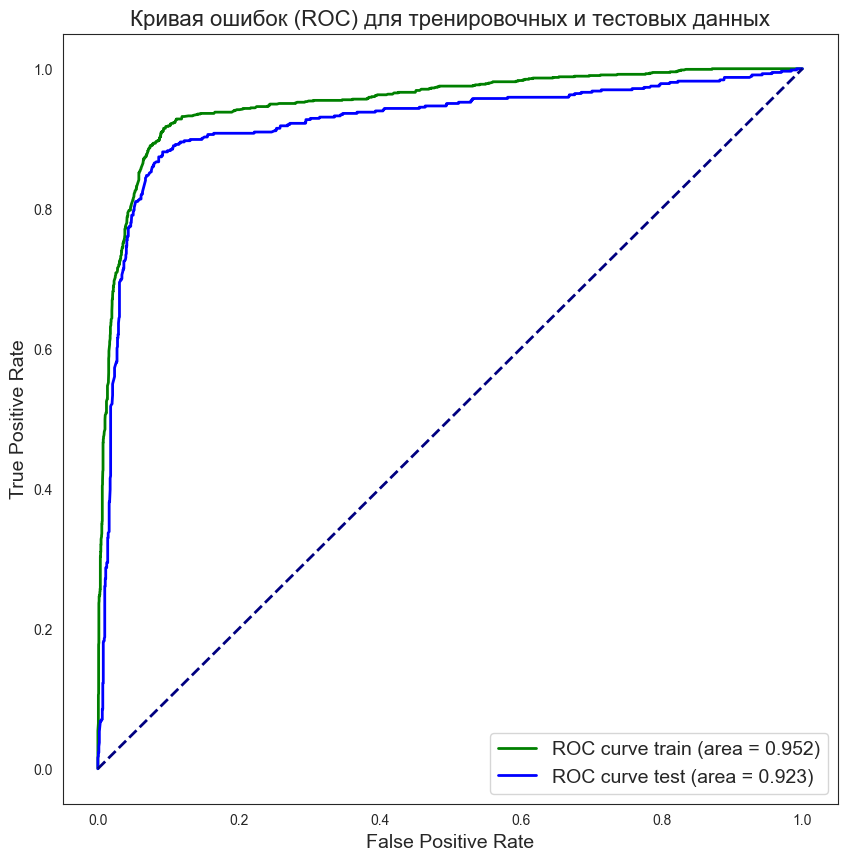

In [73]:
fpr1, tpr1, _ = roc_curve(y_train, y_train_proba)
roc_auc1 = auc(fpr1, tpr1)

# fpr2, tpr2, _ = roc_curve(y_valid, y_valid_proba)
# roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_test_proba)
roc_auc3 = auc(fpr3, tpr3)

sns.set_style('white')
plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, color='green', lw=2, label='ROC curve train (area = %0.3f)' % roc_auc1)
# plt.plot(fpr2, tpr2, color='red', lw=2, label='ROC curve valid (area = %0.3f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='blue', lw=2, label='ROC curve test (area = %0.3f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Кривая ошибок (ROC) для тренировочных, валидационных и тестовых данных', size=16)
plt.title('Кривая ошибок (ROC) для тренировочных и тестовых данных', size=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

## Выводы

С помощью валидационного поиска была опредлена лучшая предсказательная модель:
SVC(C=10, degree=2, probability=True)

С метрикой ROC-AUC на тестовых данных: 0.92


## Общий вывод

Исходная задача построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе входящих признаков, предоставленных заказчиком (уровень зарплаты, время работы в компании, отдел, уровень должности, оценка загруженности, наличие нарушений, количетво повышений). Для определения лучшей модели был построен пайплайн со случайным перебором моделей и их гиперпараметров. В "соревновании" приняли участием модели регресссии: DecisionTreeRegressor, LinearRegression, Ridge.
С предсказанием лучше справилась "деревянная" модель:

DecisionTreeRegressor с параметрами: max_depth=11, max_features=11, min_samples_split=5.
В качестве оценки использовалась собственная метрика - SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).
Значение метрики на тестовой выборке составило 14.527. Это значение удовлетворяет условию задачи (<= 15).

Наиболее сильное влияние на уровень удовлетворенности сотрудника оказывают в подядке уменьшения следующие признаки:
- оценка качества работы сотрудников руководителем
- длительность работы в компании
- зарплата
- фактор нарушения договора сотрудником в прошлом году
- уровень занимаемой должности

В результате построения графиков была выявлена связь между уровнем удовлетворенности и увольнением сотрудника. С помощью полученной модели предсказания датасет с ключевыми характеристиками персонала был обогащен признаком удовлетворенности (полученным не опросамаи, а моделью). После этого началось решение второй задачи: построить модель, которая сможет предсказать то, что сотрудник уволится из компании.

Для решения этой задачи был использован пайплайн с перебором моделей и их гиперпараметров методом случайной выборки. В этом "соревновании" приняли участие модели классификации: DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression.

С предсказанием лучше справилась модель SVC с параметрами: C=10, degree=2.
В качестве метрики использовалась метрика ROC-AUC. Показатель метрики на тестовой выборке составил 0.92.
С вероятностю 92% модель может предсказывать увольнение сотрудника.

Рекомендации для бизнеса:
Данная модель позволит предсказывать вероятность увольнения сотрудника, давая возможность не дожидаясь этого подбирая ему подходящую замену в случае увольнения. Для снижения оттока сотрудников рекомендуется уделить внимание перечисленным выше 5-ти основным признакам, влияющим на удовлетворенность.